In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-08-14 06:47:22.814487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 06:47:23.385819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-08-14 06:47:24.065342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 06:47:24.101524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 06:47:24.101808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2023-08-14 06:47:24.129794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 06:47:24.130134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 06:47:24.130343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2023-08-14 06:47:24.670806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 06:47:24.670989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 06:47:24.671111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [6]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

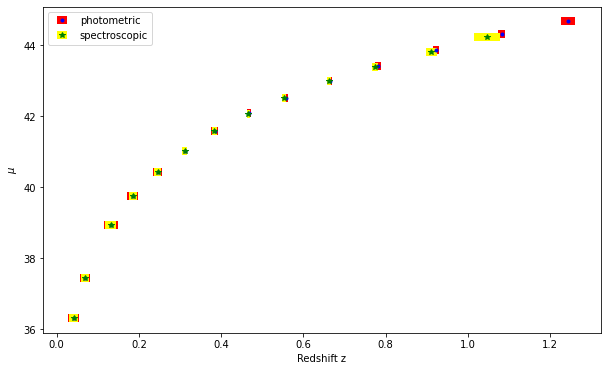

In [7]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [8]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [9]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [10]:
len(dfp)

14

In [11]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [12]:
noise1x = 0.005*np.random.rand(len(dfp))
noise1y = np.zeros((14, 2))
noise1y[:,0] = noise1x * 2
noise1y[:,1] = noise1x * 0.1

noise2x = 0.005*np.random.rand(len(dfp))
noise2y = np.zeros((14, 2))
noise2y[:,0] = noise2x * 2
noise2y[:,1] = noise2x * 0.1


In [13]:
np.shape(noise1y)

(14, 2)

In [14]:
z_or = dfp.values[:,0]
y_or = dfp.values[:,1:]

z = np.append(z_or, z_or+noise1x)
z = np.append(z, z_or+noise2x)

y = np.append(y_or, y_or+noise1y, axis=0)
y = np.append(y, y_or+noise2y, axis=0)


In [15]:
np.shape(y), np.shape(z)

((42, 2), (42,))

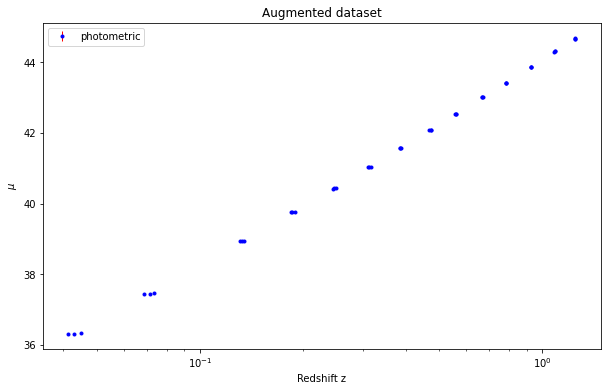

In [16]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.title("Augmented dataset")
plt.xscale('log')
plt.legend()

In [17]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z_sc = scalerz.transform(z.reshape(-1,1))
np.shape(z_sc)

(42, 1)

In [18]:
split = 0.9
ntrain = int(split * len(z))

randomize = np.random.permutation(len(z))
z = z_sc[randomize]
y = y[randomize]

indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)
np.shape(z_train), np.shape(z_test), np.shape(y_train), np.shape(y_test)

((37, 1), (5, 1), (37, 2), (5, 2))

In [19]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [20]:
yy_train = np.append(y_train, np.array([y_or[0], y_or[-1]]), axis=0)
zz_train = np.append(z_train, np.array([z_sc[0], z_sc[-1]]))
np.shape(zz_train), np.shape(yy_train)

((39,), (39, 2))

In [21]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[3], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 8
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[200,200,200,200])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               400       
                                                                 
 MCDropout_1 (MCDropout)     (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_3 (MCDropout)     (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               4

In [22]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(zz_train, yy_train, batch_size=batch_size,
                                    epochs=2500, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/2500
5/5 [==============================] - 1s 36ms/step - loss: 863.4441 - val_loss: 805.3140
Epoch 2/2500
5/5 [==============================] - 0s 6ms/step - loss: 861.4478 - val_loss: 802.7108
Epoch 3/2500
5/5 [==============================] - 0s 6ms/step - loss: 859.7387 - val_loss: 801.4902
Epoch 4/2500
5/5 [==============================] - 0s 6ms/step - loss: 857.6316 - val_loss: 800.8116
Epoch 5/2500
5/5 [==============================] - 0s 7ms/step - loss: 855.3412 - val_loss: 797.2486
Epoch 6/2500
5/5 [==============================] - 0s 6ms/step - loss: 853.0553 - val_loss: 796.5472
Epoch 7/2500
5/5 [==============================] - 0s 6ms/step - loss: 850.2764 - val_loss: 792.3307
Epoch 8/2500
5/5 [==============================] - 0s 6ms/step - loss: 847.4124 - val_loss: 789.8317
Epoch 9/2500
5/5 [==============================] - 0s 7ms/step - loss: 842.4539 - val_loss: 788.6923
Epoch 10/2500
5/5 [==============================] - 0s 6ms/step - loss: 839.0974

5/5 [==============================] - 0s 7ms/step - loss: 45.0333 - val_loss: 27.5390
Epoch 82/2500
5/5 [==============================] - 0s 6ms/step - loss: 49.1001 - val_loss: 27.6595
Epoch 83/2500
5/5 [==============================] - 0s 6ms/step - loss: 45.1579 - val_loss: 19.3638
Epoch 84/2500
5/5 [==============================] - 0s 6ms/step - loss: 54.3095 - val_loss: 19.0708
Epoch 85/2500
5/5 [==============================] - 0s 5ms/step - loss: 51.3087 - val_loss: 16.6477
Epoch 86/2500
5/5 [==============================] - 0s 6ms/step - loss: 45.6738 - val_loss: 37.8722
Epoch 87/2500
5/5 [==============================] - 0s 6ms/step - loss: 38.7436 - val_loss: 19.5822
Epoch 88/2500
5/5 [==============================] - 0s 6ms/step - loss: 39.2392 - val_loss: 27.2644
Epoch 89/2500
5/5 [==============================] - 0s 6ms/step - loss: 44.6729 - val_loss: 24.6437
Epoch 90/2500
5/5 [==============================] - 0s 6ms/step - loss: 39.9532 - val_loss: 20.3255
Epoc

5/5 [==============================] - 0s 6ms/step - loss: 6.1997 - val_loss: 1.5352
Epoch 163/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.6041 - val_loss: 1.8658
Epoch 164/2500
5/5 [==============================] - 0s 6ms/step - loss: 9.9616 - val_loss: 7.4904
Epoch 165/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.4134 - val_loss: 5.5377
Epoch 166/2500
5/5 [==============================] - 0s 8ms/step - loss: 4.5852 - val_loss: 3.5501
Epoch 167/2500
5/5 [==============================] - 0s 6ms/step - loss: 6.8014 - val_loss: 6.2039
Epoch 168/2500
5/5 [==============================] - 0s 6ms/step - loss: 6.1987 - val_loss: 7.1541
Epoch 169/2500
5/5 [==============================] - 0s 7ms/step - loss: 8.1016 - val_loss: 4.8671
Epoch 170/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.7681 - val_loss: 3.4065
Epoch 171/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.7732 - val_loss: 5.4738
Epoch 172/2500


5/5 [==============================] - 0s 6ms/step - loss: 4.9945 - val_loss: 2.1016
Epoch 245/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.6934 - val_loss: 4.7291
Epoch 246/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.2248 - val_loss: 5.5956
Epoch 247/2500
5/5 [==============================] - 0s 9ms/step - loss: 3.7924 - val_loss: 3.6390
Epoch 248/2500
5/5 [==============================] - 0s 8ms/step - loss: 5.8058 - val_loss: 6.8931
Epoch 249/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.2943 - val_loss: 5.3588
Epoch 250/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.8754 - val_loss: 2.1698
Epoch 251/2500
5/5 [==============================] - 0s 6ms/step - loss: 6.0242 - val_loss: 2.9757
Epoch 252/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.7414 - val_loss: 1.9249
Epoch 253/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.2551 - val_loss: 4.7892
Epoch 254/2500


5/5 [==============================] - 0s 7ms/step - loss: 4.1990 - val_loss: 4.9520
Epoch 327/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.6970 - val_loss: 3.1114
Epoch 328/2500
5/5 [==============================] - 0s 7ms/step - loss: 5.6495 - val_loss: 10.2840
Epoch 329/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.7286 - val_loss: 7.3969
Epoch 330/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.9309 - val_loss: 2.0310
Epoch 331/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.8219 - val_loss: 2.6788
Epoch 332/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.7160 - val_loss: 7.7375
Epoch 333/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.7597 - val_loss: 3.8515
Epoch 334/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.8297 - val_loss: 1.1692
Epoch 335/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.1293 - val_loss: 9.1128
Epoch 336/2500

5/5 [==============================] - 0s 6ms/step - loss: 4.4321 - val_loss: 2.3843
Epoch 409/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.6606 - val_loss: 5.4676
Epoch 410/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.8575 - val_loss: 2.7822
Epoch 411/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.2852 - val_loss: 1.3230
Epoch 412/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.3220 - val_loss: 2.3959
Epoch 413/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.3568 - val_loss: 7.4363
Epoch 414/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.0816 - val_loss: 4.6188
Epoch 415/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.0508 - val_loss: 3.1980
Epoch 416/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.7110 - val_loss: 1.8314
Epoch 417/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.9048 - val_loss: 7.5059
Epoch 418/2500


5/5 [==============================] - 0s 6ms/step - loss: 4.3156 - val_loss: 4.4463
Epoch 491/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.1908 - val_loss: 2.6110
Epoch 492/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.2922 - val_loss: 3.5374
Epoch 493/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.3455 - val_loss: 2.3593
Epoch 494/2500
5/5 [==============================] - 0s 6ms/step - loss: 6.1583 - val_loss: 2.0085
Epoch 495/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.5440 - val_loss: 2.9329
Epoch 496/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.8350 - val_loss: 3.4634
Epoch 497/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.7214 - val_loss: 1.2991
Epoch 498/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.2734 - val_loss: 3.0015
Epoch 499/2500
5/5 [==============================] - 0s 7ms/step - loss: 4.1101 - val_loss: 2.7833
Epoch 500/2500


5/5 [==============================] - 0s 6ms/step - loss: 4.0515 - val_loss: 2.4298
Epoch 573/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.0390 - val_loss: 2.7206
Epoch 574/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.8264 - val_loss: 2.5158
Epoch 575/2500
5/5 [==============================] - 0s 6ms/step - loss: 6.6919 - val_loss: 1.2606
Epoch 576/2500
5/5 [==============================] - 0s 6ms/step - loss: 6.2910 - val_loss: 2.9146
Epoch 577/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.6696 - val_loss: 5.4168
Epoch 578/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.0711 - val_loss: 5.5757
Epoch 579/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.2459 - val_loss: 2.0709
Epoch 580/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.3392 - val_loss: 6.1979
Epoch 581/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.8928 - val_loss: 2.8344
Epoch 582/2500


5/5 [==============================] - 0s 6ms/step - loss: 4.2512 - val_loss: 1.4090
Epoch 655/2500
5/5 [==============================] - 0s 6ms/step - loss: 6.1489 - val_loss: 3.9820
Epoch 656/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.7135 - val_loss: 2.5934
Epoch 657/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.6010 - val_loss: 6.7146
Epoch 658/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.6449 - val_loss: 3.9693
Epoch 659/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9120 - val_loss: 1.3718
Epoch 660/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9333 - val_loss: 1.7336
Epoch 661/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.3917 - val_loss: 4.9815
Epoch 662/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.4836 - val_loss: 3.1219
Epoch 663/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.3601 - val_loss: 1.8781
Epoch 664/2500


5/5 [==============================] - 0s 7ms/step - loss: 4.8669 - val_loss: 3.4149
Epoch 737/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.7826 - val_loss: 4.3258
Epoch 738/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.8432 - val_loss: 2.1063
Epoch 739/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9837 - val_loss: 4.0943
Epoch 740/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.3838 - val_loss: 3.2092
Epoch 741/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.5977 - val_loss: 1.0067
Epoch 742/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.4703 - val_loss: 4.8853
Epoch 743/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.0437 - val_loss: 3.8212
Epoch 744/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.9005 - val_loss: 2.7009
Epoch 745/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.8280 - val_loss: 6.1720
Epoch 746/2500


5/5 [==============================] - 0s 6ms/step - loss: 3.6592 - val_loss: 3.8031
Epoch 819/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.4842 - val_loss: 1.6077
Epoch 820/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.3411 - val_loss: 7.5458
Epoch 821/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.1387 - val_loss: 2.6555
Epoch 822/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.7000 - val_loss: 2.2949
Epoch 823/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.7029 - val_loss: 6.3078
Epoch 824/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.8577 - val_loss: 6.0471
Epoch 825/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.6926 - val_loss: 1.9973
Epoch 826/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.1104 - val_loss: 3.5877
Epoch 827/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.0727 - val_loss: 3.4550
Epoch 828/2500


5/5 [==============================] - 0s 6ms/step - loss: 3.8915 - val_loss: 3.7149
Epoch 901/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.8668 - val_loss: 4.3297
Epoch 902/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.5753 - val_loss: 3.0230
Epoch 903/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.1260 - val_loss: 4.1067
Epoch 904/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.7059 - val_loss: 2.0486
Epoch 905/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.9987 - val_loss: 2.4808
Epoch 906/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.1882 - val_loss: 1.9377
Epoch 907/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.0782 - val_loss: 3.1312
Epoch 908/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.5912 - val_loss: 4.2845
Epoch 909/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.8335 - val_loss: 3.8247
Epoch 910/2500


5/5 [==============================] - 0s 5ms/step - loss: 4.2442 - val_loss: 3.7697
Epoch 983/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9694 - val_loss: 1.8925
Epoch 984/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.2256 - val_loss: 0.9046
Epoch 985/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.8223 - val_loss: 2.9715
Epoch 986/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.6202 - val_loss: 5.5766
Epoch 987/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.1091 - val_loss: 1.6595
Epoch 988/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.0621 - val_loss: 1.5418
Epoch 989/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.7307 - val_loss: 0.9703
Epoch 990/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.0257 - val_loss: 1.8532
Epoch 991/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.6993 - val_loss: 1.6602
Epoch 992/2500


5/5 [==============================] - 0s 6ms/step - loss: 2.6356 - val_loss: 4.8574
Epoch 1064/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.3283 - val_loss: 2.2112
Epoch 1065/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.2163 - val_loss: 2.6804
Epoch 1066/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4531 - val_loss: 2.6771
Epoch 1067/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.5073 - val_loss: 1.8896
Epoch 1068/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.5871 - val_loss: 1.5172
Epoch 1069/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.4945 - val_loss: 0.8841
Epoch 1070/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.0398 - val_loss: 3.4516
Epoch 1071/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.5552 - val_loss: 3.0728
Epoch 1072/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.6360 - val_loss: 4.8301
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 4.0974 - val_loss: 1.1713
Epoch 1145/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.4159 - val_loss: 2.3929
Epoch 1146/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.3143 - val_loss: 4.1248
Epoch 1147/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.9271 - val_loss: 4.2158
Epoch 1148/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.6917 - val_loss: 5.9379
Epoch 1149/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.2550 - val_loss: 1.0140
Epoch 1150/2500
5/5 [==============================] - 0s 5ms/step - loss: 3.2166 - val_loss: 3.8124
Epoch 1151/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.8700 - val_loss: 2.6402
Epoch 1152/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4458 - val_loss: 1.8325
Epoch 1153/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.8288 - val_loss: 7.0505
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 2.4485 - val_loss: 2.1568
Epoch 1226/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.1682 - val_loss: 2.5588
Epoch 1227/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.4214 - val_loss: 4.4153
Epoch 1228/2500
5/5 [==============================] - 0s 5ms/step - loss: 3.6290 - val_loss: 4.3848
Epoch 1229/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.5312 - val_loss: 1.0427
Epoch 1230/2500
5/5 [==============================] - 0s 5ms/step - loss: 3.3063 - val_loss: 0.7175
Epoch 1231/2500
5/5 [==============================] - 0s 5ms/step - loss: 4.0481 - val_loss: 3.9923
Epoch 1232/2500
5/5 [==============================] - 0s 7ms/step - loss: 1.8036 - val_loss: 7.2359
Epoch 1233/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.2667 - val_loss: 2.1428
Epoch 1234/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.7105 - val_loss: 2.2949
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 2.9917 - val_loss: 2.4549
Epoch 1307/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.0996 - val_loss: 1.0243
Epoch 1308/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.0142 - val_loss: 3.3614
Epoch 1309/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9018 - val_loss: 4.6650
Epoch 1310/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.0793 - val_loss: 1.6388
Epoch 1311/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.7541 - val_loss: 1.0172
Epoch 1312/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.5586 - val_loss: 3.6241
Epoch 1313/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9574 - val_loss: 0.7297
Epoch 1314/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.6853 - val_loss: 3.0856
Epoch 1315/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.6589 - val_loss: 1.4925
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 2.6281 - val_loss: 0.8154
Epoch 1388/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9773 - val_loss: 4.4748
Epoch 1389/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.3110 - val_loss: 0.4790
Epoch 1390/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.7302 - val_loss: 1.5783
Epoch 1391/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4720 - val_loss: 2.4785
Epoch 1392/2500
5/5 [==============================] - 0s 5ms/step - loss: 3.5896 - val_loss: 2.0521
Epoch 1393/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.2321 - val_loss: 0.7517
Epoch 1394/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9311 - val_loss: 1.3916
Epoch 1395/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.1537 - val_loss: 2.1819
Epoch 1396/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.9439 - val_loss: 2.2180
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 2.2302 - val_loss: 2.8117
Epoch 1469/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.8948 - val_loss: 2.6933
Epoch 1470/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.4753 - val_loss: 3.6195
Epoch 1471/2500
5/5 [==============================] - 0s 5ms/step - loss: 3.1758 - val_loss: 1.4875
Epoch 1472/2500
5/5 [==============================] - 0s 5ms/step - loss: 3.8787 - val_loss: 1.4309
Epoch 1473/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.7333 - val_loss: 2.7024
Epoch 1474/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.1600 - val_loss: 1.8675
Epoch 1475/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4714 - val_loss: 1.5858
Epoch 1476/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.8797 - val_loss: 5.4435
Epoch 1477/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.1358 - val_loss: 1.1802
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 3.2928 - val_loss: 3.6346
Epoch 1550/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.8910 - val_loss: 1.0623
Epoch 1551/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.5911 - val_loss: 1.7101
Epoch 1552/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.5991 - val_loss: 4.3773
Epoch 1553/2500
5/5 [==============================] - 0s 5ms/step - loss: 1.9169 - val_loss: 1.8454
Epoch 1554/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.4266 - val_loss: 4.7719
Epoch 1555/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.6760 - val_loss: 3.1413
Epoch 1556/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4481 - val_loss: 4.2177
Epoch 1557/2500
5/5 [==============================] - 0s 5ms/step - loss: 5.5630 - val_loss: 0.7128
Epoch 1558/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.5638 - val_loss: 1.2913
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 2.9854 - val_loss: 3.4696
Epoch 1631/2500
5/5 [==============================] - 0s 5ms/step - loss: 3.2890 - val_loss: 3.1609
Epoch 1632/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.1273 - val_loss: 3.0322
Epoch 1633/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.7635 - val_loss: 1.5977
Epoch 1634/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9979 - val_loss: 3.6620
Epoch 1635/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.3029 - val_loss: 1.7380
Epoch 1636/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.5170 - val_loss: 3.1899
Epoch 1637/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4153 - val_loss: 1.2553
Epoch 1638/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.3516 - val_loss: 3.8022
Epoch 1639/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.2486 - val_loss: 5.2135
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 2.2555 - val_loss: 1.0999
Epoch 1712/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.7483 - val_loss: 3.2126
Epoch 1713/2500
5/5 [==============================] - 0s 6ms/step - loss: 5.0335 - val_loss: 4.8449
Epoch 1714/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.1732 - val_loss: 1.4259
Epoch 1715/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.1459 - val_loss: 3.0306
Epoch 1716/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.7057 - val_loss: 1.3852
Epoch 1717/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.5731 - val_loss: 1.4648
Epoch 1718/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.0286 - val_loss: 3.4049
Epoch 1719/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.1275 - val_loss: 1.9820
Epoch 1720/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.7124 - val_loss: 2.4377
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 2.6752 - val_loss: 1.1966
Epoch 1793/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.9858 - val_loss: 2.8901
Epoch 1794/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.0654 - val_loss: 3.5575
Epoch 1795/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.0819 - val_loss: 1.0928
Epoch 1796/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.3524 - val_loss: 1.6921
Epoch 1797/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.7524 - val_loss: 1.2618
Epoch 1798/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.5930 - val_loss: 0.7584
Epoch 1799/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.3683 - val_loss: 3.2866
Epoch 1800/2500
5/5 [==============================] - 0s 5ms/step - loss: 3.8425 - val_loss: 3.5873
Epoch 1801/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.8793 - val_loss: 2.7311
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 2.4627 - val_loss: 1.7895
Epoch 1874/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.5957 - val_loss: 3.4342
Epoch 1875/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.1670 - val_loss: 2.2205
Epoch 1876/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.6179 - val_loss: 2.5487
Epoch 1877/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.5373 - val_loss: 2.1629
Epoch 1878/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.3912 - val_loss: 0.7523
Epoch 1879/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.2594 - val_loss: 2.8990
Epoch 1880/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4946 - val_loss: 1.0476
Epoch 1881/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.5460 - val_loss: 0.9834
Epoch 1882/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.9121 - val_loss: 1.2151
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 2.0969 - val_loss: 1.2491
Epoch 1955/2500
5/5 [==============================] - 0s 5ms/step - loss: 1.6205 - val_loss: 3.4526
Epoch 1956/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.8901 - val_loss: 0.6362
Epoch 1957/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.2611 - val_loss: 1.1491
Epoch 1958/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.8872 - val_loss: 4.0437
Epoch 1959/2500
5/5 [==============================] - 0s 6ms/step - loss: 4.3151 - val_loss: 2.4561
Epoch 1960/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.5642 - val_loss: 2.8835
Epoch 1961/2500
5/5 [==============================] - 0s 5ms/step - loss: 3.2500 - val_loss: 2.8865
Epoch 1962/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.6741 - val_loss: 2.0759
Epoch 1963/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.3712 - val_loss: 1.8767
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 2.6982 - val_loss: 1.3414
Epoch 2036/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.4773 - val_loss: 4.3721
Epoch 2037/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.0065 - val_loss: 1.0019
Epoch 2038/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.3513 - val_loss: 3.1057
Epoch 2039/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.8501 - val_loss: 0.9086
Epoch 2040/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.6373 - val_loss: 6.8217
Epoch 2041/2500
5/5 [==============================] - 0s 5ms/step - loss: 1.7048 - val_loss: 1.8985
Epoch 2042/2500
5/5 [==============================] - 0s 9ms/step - loss: 3.3542 - val_loss: 1.0358
Epoch 2043/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.3686 - val_loss: 0.9025
Epoch 2044/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.2927 - val_loss: 2.2469
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 2.3787 - val_loss: 2.2847
Epoch 2117/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.0213 - val_loss: 2.3577
Epoch 2118/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4304 - val_loss: 4.2329
Epoch 2119/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.2957 - val_loss: 1.5039
Epoch 2120/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9082 - val_loss: 1.5163
Epoch 2121/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9423 - val_loss: 1.8703
Epoch 2122/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4398 - val_loss: 0.6683
Epoch 2123/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.6309 - val_loss: 0.2937
Epoch 2124/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.7138 - val_loss: 5.1881
Epoch 2125/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.7431 - val_loss: 1.4973
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 1.8153 - val_loss: 1.0573
Epoch 2198/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.9906 - val_loss: 2.0430
Epoch 2199/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.8847 - val_loss: 1.3493
Epoch 2200/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.2610 - val_loss: 1.6162
Epoch 2201/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4968 - val_loss: 1.9764
Epoch 2202/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.1997 - val_loss: 1.6115
Epoch 2203/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.2576 - val_loss: 4.0042
Epoch 2204/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.1774 - val_loss: 0.2163
Epoch 2205/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.0246 - val_loss: 5.6510
Epoch 2206/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9141 - val_loss: 5.4370
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 3.6375 - val_loss: 0.8496
Epoch 2279/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.2469 - val_loss: 0.9776
Epoch 2280/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.0401 - val_loss: 4.6903
Epoch 2281/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.9130 - val_loss: 3.7856
Epoch 2282/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.3681 - val_loss: 1.9310
Epoch 2283/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.1529 - val_loss: 2.2630
Epoch 2284/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.3845 - val_loss: 3.4736
Epoch 2285/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.9087 - val_loss: 3.3610
Epoch 2286/2500
5/5 [==============================] - 0s 5ms/step - loss: 1.6348 - val_loss: 4.7886
Epoch 2287/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.4867 - val_loss: 2.1391
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 2.1215 - val_loss: 1.8915
Epoch 2360/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.7263 - val_loss: 1.1211
Epoch 2361/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.7059 - val_loss: 3.9768
Epoch 2362/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.3164 - val_loss: 2.0090
Epoch 2363/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.4746 - val_loss: 3.5265
Epoch 2364/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.3501 - val_loss: 3.4125
Epoch 2365/2500
5/5 [==============================] - 0s 5ms/step - loss: 2.9376 - val_loss: 1.1043
Epoch 2366/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.2654 - val_loss: 3.0306
Epoch 2367/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.9506 - val_loss: 1.6722
Epoch 2368/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.0277 - val_loss: 0.5288
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 3.4737 - val_loss: 2.1299
Epoch 2441/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.7280 - val_loss: 1.5062
Epoch 2442/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.5995 - val_loss: 5.7956
Epoch 2443/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.5961 - val_loss: 1.3530
Epoch 2444/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.0818 - val_loss: 1.4131
Epoch 2445/2500
5/5 [==============================] - 0s 6ms/step - loss: 1.4571 - val_loss: 0.5428
Epoch 2446/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.0237 - val_loss: 1.9345
Epoch 2447/2500
5/5 [==============================] - 0s 6ms/step - loss: 3.0632 - val_loss: 2.4684
Epoch 2448/2500
5/5 [==============================] - 0s 5ms/step - loss: 1.9773 - val_loss: 3.4927
Epoch 2449/2500
5/5 [==============================] - 0s 6ms/step - loss: 2.3519 - val_loss: 1.5753
Epoch 

In [23]:
model_train.history['val_loss'][-1]

5.54036283493042

In [26]:
model.save('models/short_lsst_data_model.h5')

(0.0, 200.0)

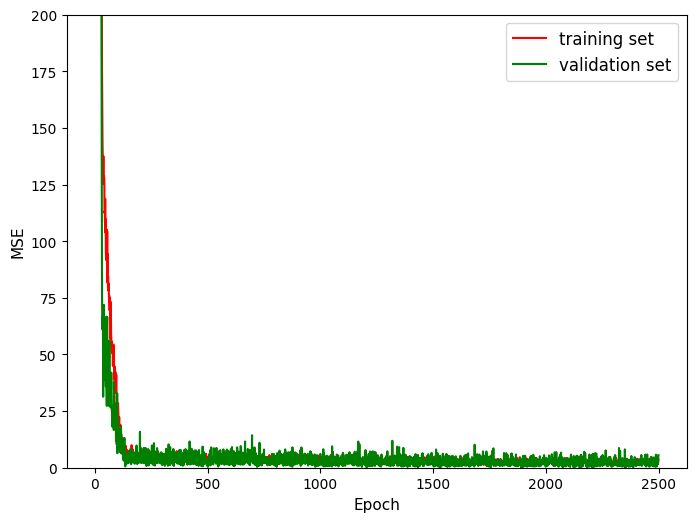

In [27]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)

In [28]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.3, test_batch_size)

mc_dropout_num = 200 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 946us/step


16/16 [==============================] - 0s 958us/step


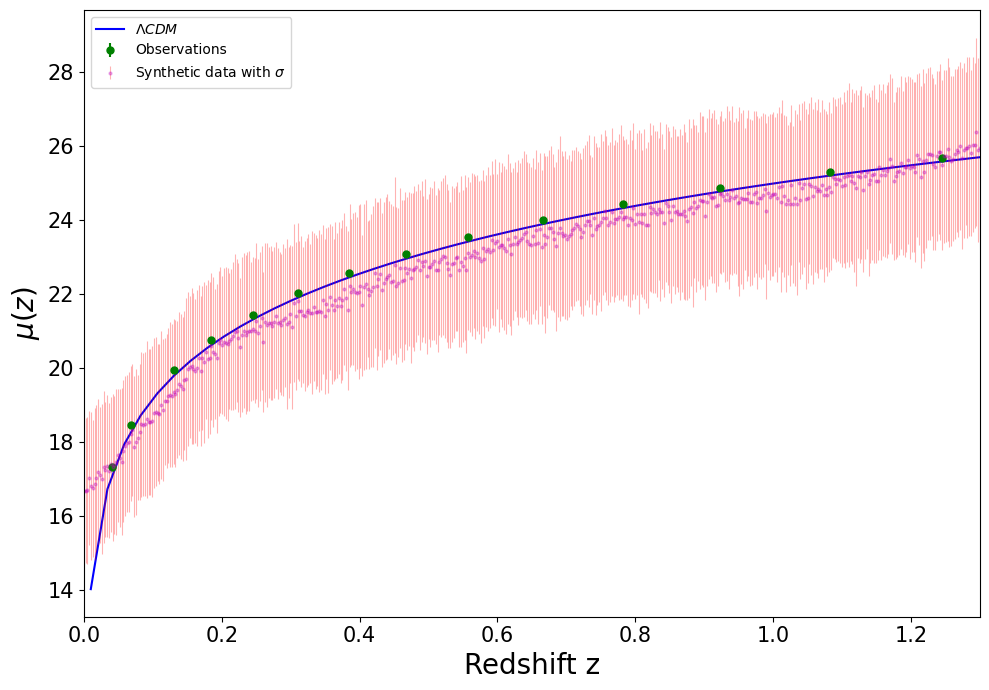

In [29]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()
plt.savefig('firs_model.png', dpi=100)
# zCMB 	MU 	errors